In [105]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from cynetdiff.utils import networkx_to_ic_model
from cynetdiff.models import DiffusionModel
import numpy as np
from coloraide import Color
import heapq
import tqdm
import time

from benchmarks import compute_marginal_gain

Graph = nx.Graph | nx.DiGraph

In [106]:
def create_plot_for_nodes_infected_perc(
    graphs: Graph | list[Graph],
    plot_iqr: bool = False,
):
    # TODO Dhemath, see if there's a way to fix the bar running out on the shorter experiments.
    """
    Create a plot of the percentage of nodes infected for a CyNetDiff model across multiple trials for up to four graphs.
    If plot_iqr is True, plots the interquartile range and horizontal lines.
    """

    if not isinstance(graphs, list):
        graphs = [graphs]

    # Generate distinct colors for each graph using Coloraide
    colors = [Color.random("srgb") for _ in graphs]

    # Generate distinct lighter-colors for each graph for IQR plotting
    light_colors = []
    for color_str in colors:
        color = Color(color_str, "srgb")
        color[3] = 0.5
        light_colors.append(color)

    max_length = 0
    all_graphs_data = []

    # Get all the data for graphs
    for graph in graphs:
        model = networkx_to_ic_model(graph)
        seeds = set(random.sample(list(graph.nodes()), 100))
        model.set_seeds(seeds)
        num_trials = 100

        all_trials_infected_nodes = []

        for _ in range(num_trials):
            model.reset_model()

            infected_nodes_over_time = []
            previous_activated = -1
            current_activated = 0

            while previous_activated != current_activated:
                previous_activated = current_activated
                model.advance_model()
                current_activated = model.get_num_activated_nodes()
                number_infected = current_activated
                infected_nodes_over_time.append(number_infected)

            all_trials_infected_nodes.append(infected_nodes_over_time)
            max_length = max(max_length, len(infected_nodes_over_time))

        all_graphs_data.append(all_trials_infected_nodes)

    # Pad all data
    padded_all_graphs_data = []
    for graph_data in all_graphs_data:
        padded_trials = [
            trial + [trial[-1]] * (max_length - len(trial)) for trial in graph_data
        ]
        padded_all_graphs_data.append(padded_trials)

    # Graph Data
    for idx, graph_data in enumerate(padded_all_graphs_data):
        median_infected = np.median(graph_data, axis=0)

        if plot_iqr:
            iqr_values = [
                np.percentile(
                    [trial[i] if i < len(trial) else trial[-1] for trial in graph_data],
                    [25, 75],
                )
                for i in range(max_length)
            ]
            lower_quartile, upper_quartile = zip(*iqr_values)

            for y in median_infected:
                plt.axhline(y=y, color=colors[idx], linestyle="--", alpha=0.2)

            plt.fill_between(
                range(max_length),
                lower_quartile,
                upper_quartile,
                color=light_colors[idx],
                alpha=0.3,
            )

        plt.plot(
            median_infected, label=f"Graph {idx+1} Median Infected", color=colors[idx]
        )

    plt.xlabel("Iteration")
    plt.ylabel("Number of Infected Nodes")
    plt.title("Diffusion Process Over Time")
    plt.legend()
    plt.show()

In [107]:
def create_plot_for_delta_nodes_infected(
    graph1: nx.Graph,
    graph2: nx.Graph = None,
    graph3: nx.Graph = None,
    graph4: nx.Graph = None,
    plot_iqr: bool = False,
):
    """
    Create a plot of the delta of nodes infected for a CyNetDiff model across multiple trials for up to four graphs.
    If plot_iqr is True, plots the interquartile range and horizontal lines.
    """
    graphs = [g for g in [graph1, graph2, graph3, graph4] if g is not None]
    for graph in graphs:
        model = networkx_to_ic_model(graph)
        seeds = set(random.sample(list(graph.nodes()), 100))
        model.set_seeds(seeds)
        num_trials = 1

        all_trials_delta_nodes = []
        max_length = 0

        for _ in range(num_trials):
            model.reset_model()

            delta_nodes_over_time = []
            previous_activated = -1
            current_activated = 0

            while previous_activated != current_activated:
                previous_activated = current_activated
                model.advance_model()
                current_activated = model.get_num_activated_nodes()
                delta_nodes_over_time.append(current_activated - previous_activated)

            max_length = max(max_length, len(delta_nodes_over_time))
            all_trials_delta_nodes.append(delta_nodes_over_time)

        padded_trials = [
            trial + [0] * (max_length - len(trial)) for trial in all_trials_delta_nodes
        ]

        median_delta = np.median(padded_trials, axis=0)

        if plot_iqr:
            iqr_values = [
                np.percentile(
                    [trial[i] if i < len(trial) else 0 for trial in padded_trials],
                    [25, 75],
                )
                for i in range(max_length)
            ]
            lower_quartile, upper_quartile = zip(*iqr_values)

            for y in median_delta:
                plt.axhline(y=y, color="gray", linestyle="--", alpha=0.2)

            plt.fill_between(
                range(len(lower_quartile)),
                lower_quartile,
                upper_quartile,
                color="#7daec7",
                alpha=0.3,
            )

        plt.plot(median_delta, label="Median Delta Nodes", color="#3f83a6")

    plt.xlabel("Iteration")
    plt.ylabel("Delta Nodes Infected")
    plt.title("Diffusion Process Over Time")
    plt.legend()
    plt.show()

In [108]:
# O = nx.fast_gnp_random_graph(15000, 2)
graphs = []

base_graph = nx.watts_strogatz_graph(15_000, 10, 0.01)


graphs = [
    nx.watts_strogatz_graph(15_000, 10, 0.01),
    nx.watts_strogatz_graph(15_000, 10, 0.02),
    nx.watts_strogatz_graph(15_000, 10, 0.05),
    nx.watts_strogatz_graph(15_000, 10, 0.10),
    nx.watts_strogatz_graph(15_000, 10, 0.20),
]
graph = nx.watts_strogatz_graph(15_000, 10, 0.01)
# B = nx.erdos_renyi_graph(100, 0.1)
# nx.set_edge_attributes(G, 0.01, "activation_prob")
# nx.set_edge_attributes(O, 0.01, "activation_prob")
# nx.set_edge_attributes(B, 0.01, "activation_prob")

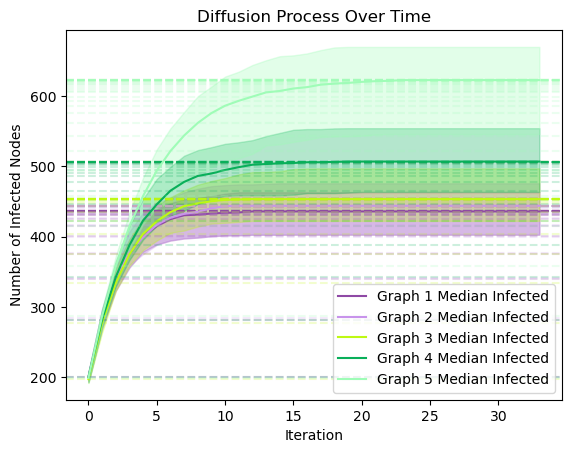

In [109]:
create_plot_for_nodes_infected_perc(graphs, True)

In [110]:
len(sorted(graphs[1].nodes()))

15000

In [111]:
model = networkx_to_ic_model(graph)
compute_marginal_gain(model, 12, set(random.sample(list(graph.nodes()), 1000)))

-5.432

In [112]:
def celf(
    graph: Graph, k: int, p: float = 0.1, mc: int = 1_000
) -> tuple[set[int], list[float]]:
    """
    Input: graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    Code adapted from this blog post:
    https://hautahi.com/im_greedycelf
    """

    model = networkx_to_ic_model(graph)

    marg_gain = [
        (-compute_marginal_gain(model, node, set(), mc), node)
        for node in (graph.nodes())
    ]

    heapq.heapify(marg_gain)

    max_mg, selected_node = heapq.heappop(marg_gain)
    S = {selected_node}
    spread = -max_mg
    spreads = [spread]

    for _ in tqdm.notebook.trange(k - 1):
        while True:
            current_mg, current_node = heapq.heappop(marg_gain)
            print(current_mg, current_node)
            new_mg_neg = -compute_marginal_gain(model, current_node, S, mc)

            if new_mg_neg > current_mg:
                heapq.heappush(marg_gain, (new_mg_neg, current_node))
                break
            else:
                heapq.heappush(marg_gain, (current_mg, current_node))

        spread += -new_mg_neg
        S.add(current_node)
        spreads.append(spread)

    return S, spreads

In [113]:
large_graph = nx.watts_strogatz_graph(1_000, 10, 0.01)

In [115]:
celf(large_graph, 20, 1, 1_000)

  0%|          | 0/19 [00:00<?, ?it/s]

-5.103 337
-5.041 338
-5.011 764
-5.009 391
-5.009 400
-4.988 336
-4.983 530
-4.98 892
-4.972 598
-4.959 337
-4.951 807
-4.951 807
-4.949 333
-4.935 217
-4.92 56
-4.92 56
-4.901 263
-4.899 228
-4.862 672
-4.848 585
-4.847 227


({56,
  217,
  227,
  228,
  263,
  333,
  336,
  337,
  338,
  391,
  400,
  462,
  530,
  585,
  598,
  672,
  764,
  807,
  892},
 [5.216,
  10.175,
  12.871,
  17.253,
  21.431,
  25.679000000000002,
  26.526000000000003,
  30.889000000000003,
  34.934000000000005,
  39.145,
  39.554,
  44.351,
  45.253,
  49.537,
  53.693,
  57.364,
  61.666,
  65.381,
  68.973,
  71.616])